# B-Splines, Cherry Blossom dataset

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
az.style.use("arviz-darkgrid")
SEED = 7355608

In [3]:
SEED = 7355608

## Cargar data

Cargamos el dataset ``cherry_blossoms`` directamente con Bambi.  
Este dataset representa el día del año del primer florecimiento de la flor de cerezo gris pálido entre los años 801 y 2015. 

In [4]:
data = bmb.load_data("cherry_blossoms")
data = data.dropna(subset=["doy"]).reset_index(drop=True)
data.head()

,year,doy,temp,temp_upper,temp_lower
0,812,92.0,NaN,NaN,NaN
1,815,105.0,NaN,NaN,NaN
2,831,96.0,NaN,NaN,NaN
3,851,108.0,7.38,12.1,2.66
4,853,104.0,NaN,NaN,NaN


La variable a modelar es ``"doy"`` (Day of Year).

## Explorar data

Exploremos los valores de ``"doy"`` for cada año.

In [5]:
def plot_scatter(data, figsize=(10, 6)):
    _, ax = plt.subplots(figsize=figsize)
    ax.scatter(data["year"], data["doy"], alpha=0.4, s=30)
    ax.set_title("Day of the first bloom per year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Days of the first bloom")
    return ax

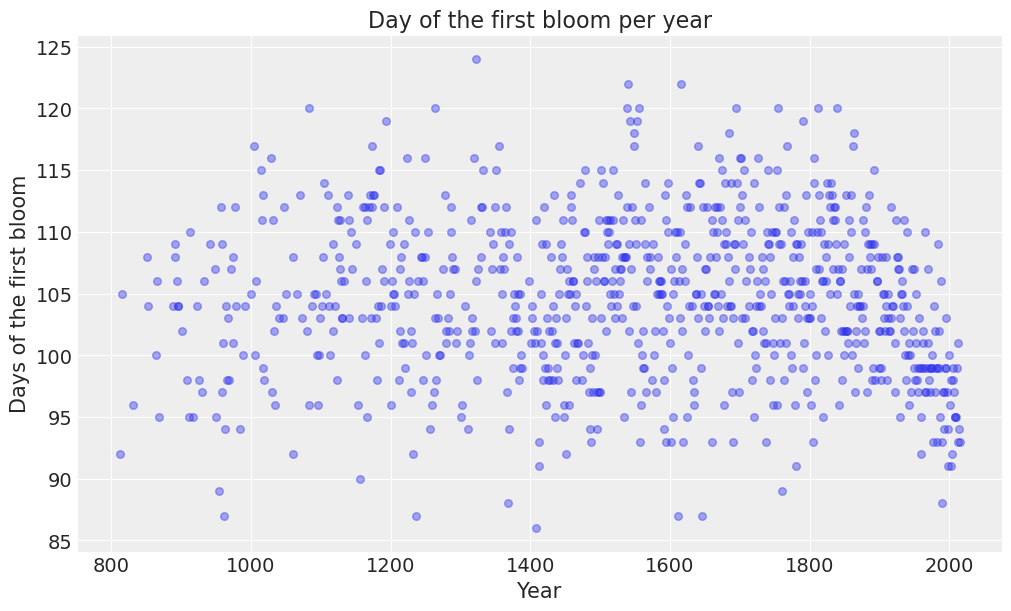

In [6]:
plot_scatter(data);

Podemos ver que el día del primer florecimiento va entre 85 y 125, lo que corresponde a finales de Marzo y principios de Mayo. En promedio, el primer florecimiento ocurre en el día 105 del año.

## Nodos

Se decide que el spline tenga 15 nodos. Estos nodos son los límites de las funciones base y dividen el rango de la variable ``"year"`` en 16 secciones.  
Las funciones bases serían los polinomios de cada sección.  
El spline resultante será uno cúbico, ya que los polinomios serán de grado 3.

Como no se tienen observaciones para todos los años, se decide dividir el espacio en cuantiles para así tener la misma cantidad de observaciones en cada sección.

In [7]:
num_knots = 15
knots = np.quantile(data["year"], np.linspace(0, 1, num_knots))

In [8]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

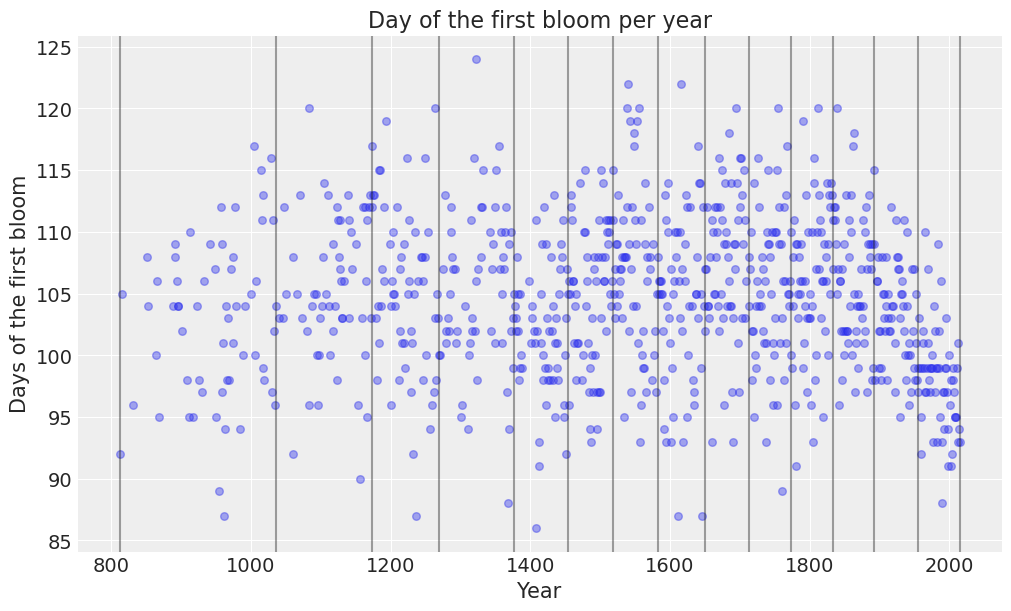

In [9]:
ax = plot_scatter(data)
plot_knots(knots, ax);

En el gráfico vemos las seccíones determinadas por los nodos

## Modelo

Para la distribución de $Y$ usamos una normal:
$$
Y_i \sim Normal(\mu_i, \sigma)
$$
La media $\mu$ es donde entran los splines:
$$
\mu_i = \alpha + \sum^K_{k=1}w_kB_{k,i}
$$
Así, para cada observación $i$, la media es influenciada por todas las funciones base y un intercepto $\alpha$. Los pesos $w_k$ son los coeficientes de la regresión de cada función base $B_k$  
Las distribuciones a priori utilizadas serán:  
$$
\alpha \sim Normal(100, 10)
$$
$$
w_k \sim Normal(0, 10)
$$
$$
\alpha \sim Exponential(1)
$$

In [10]:
iknots = knots[1:-1]

priors = {
    "Intercept": bmb.Prior("Normal", mu=100, sigma=10), # alpha
    "common": bmb.Prior("Normal", mu=0, sigma=10), # w
    "sigma": bmb.Prior("Exponential", lam=1)
}

model = bmb.Model("doy ~ bs(year, knots=iknots, intercept=True)", data, priors=priors)
model

       Formula: doy ~ bs(year, knots=iknots, intercept=True)
        Family: gaussian
          Link: mu = identity
  Observations: 827
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 100.0, sigma: 10.0)
            bs(year, knots=iknots, intercept=True) ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [11]:
def plot_spline_basis(basis, year, figsize=(10, 6), ax=None):
    df = (
        pd.DataFrame(basis)
        .assign(year=year)
        .melt("year", var_name="basis_idx", value_name="value")
    )

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    for idx in df.basis_idx.unique():
        d = df[df.basis_idx == idx]
        ax.plot(d["year"], d["value"])
    
    return ax

Visualizamos los b-splines base. La superposición entre los polinomios quiere decir que la función de regresión por más de un polinomio en cada momento. 

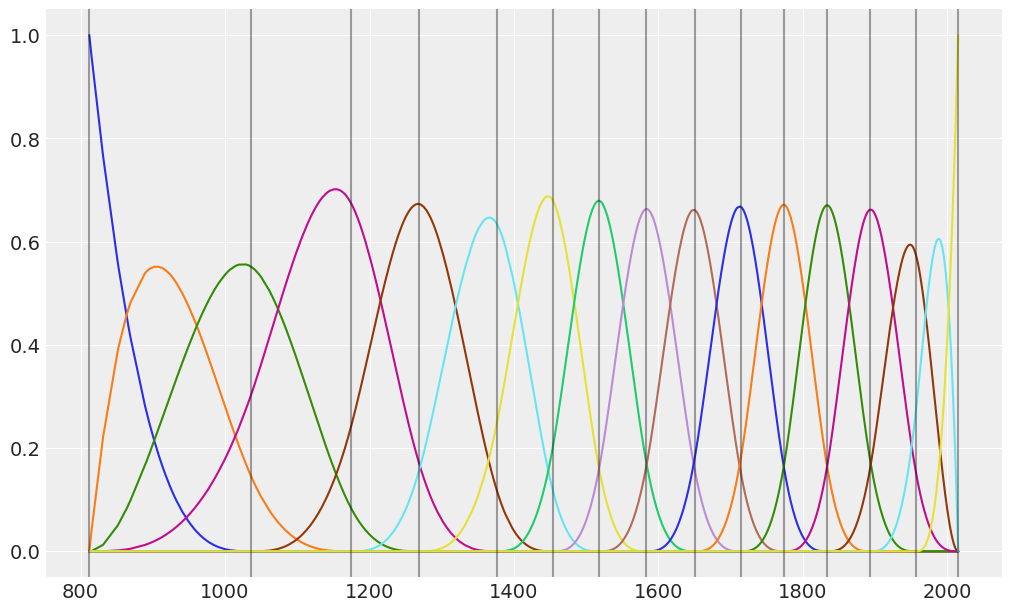

In [12]:
B = model.components['doy'].design.common['bs(year, knots=iknots, intercept=True)']
ax = plot_spline_basis(B, data["year"].values)
plot_knots(knots, ax);

Tenemos 17 polinomios, uno para cada sección más uno para el intercepto (``intercept=True``)

## Fit

In [13]:
idata = model.fit(random_seed=SEED, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [doy_sigma, Intercept, bs(year, knots=iknots, intercept=True)]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Analisis de los resultados

Se usa ``az.summary()`` para analizar los diagnósticos ``ess`` y ``r_hat``.  Se obtuvieron valores un poco bajos para ``ess``, igualmente está dentro de lo recomendad (por encima de 100 por cadena).  

In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,103.585,2.376,99.028,107.840,0.118,0.083,409.0,498.0,1.0
"bs(year, knots=iknots, intercept=True)[0]",-3.199,3.796,-10.397,3.914,0.118,0.084,1032.0,1143.0,1.0
"bs(year, knots=iknots, intercept=True)[1]",-1.163,3.929,-8.423,6.338,0.139,0.099,796.0,1185.0,1.0
"bs(year, knots=iknots, intercept=True)[2]",-1.308,3.531,-8.156,4.965,0.128,0.091,761.0,1176.0,1.0
"bs(year, knots=iknots, intercept=True)[3]",4.645,2.932,-0.961,9.958,0.124,0.088,559.0,868.0,1.0
"bs(year, knots=iknots, intercept=True)[4]",-1.095,2.902,-6.436,4.429,0.121,0.086,576.0,993.0,1.0
"bs(year, knots=iknots, intercept=True)[5]",4.114,2.925,-0.857,9.896,0.125,0.088,549.0,889.0,1.0
"bs(year, knots=iknots, intercept=True)[6]",-5.574,2.851,-10.765,-0.390,0.120,0.085,562.0,853.0,1.0
"bs(year, knots=iknots, intercept=True)[7]",7.609,2.785,2.372,12.685,0.120,0.085,537.0,915.0,1.0
"bs(year, knots=iknots, intercept=True)[8]",-1.233,2.879,-6.733,3.697,0.121,0.086,561.0,693.0,1.0


Por las dudas podemos plotear las trazas

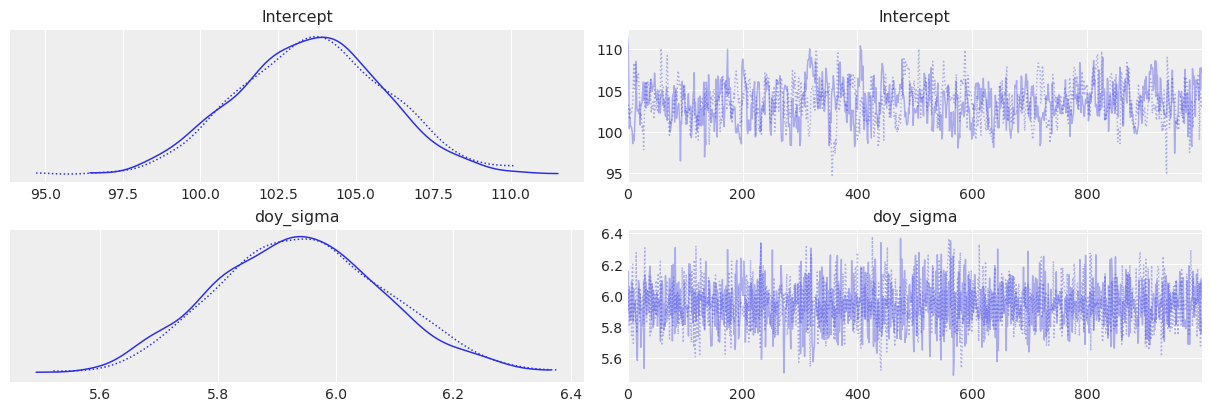

In [15]:
az.plot_trace(idata, var_names=['Intercept', 'doy_sigma']);

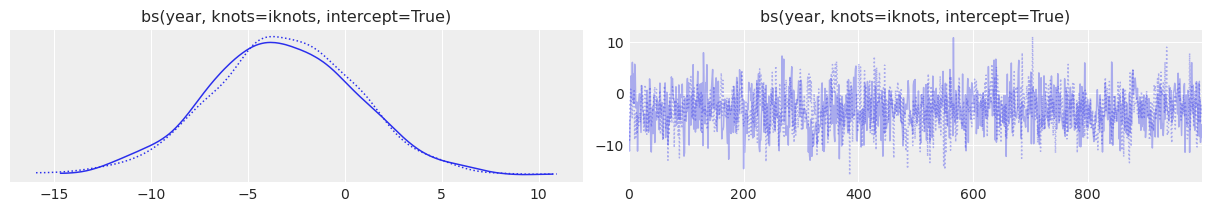

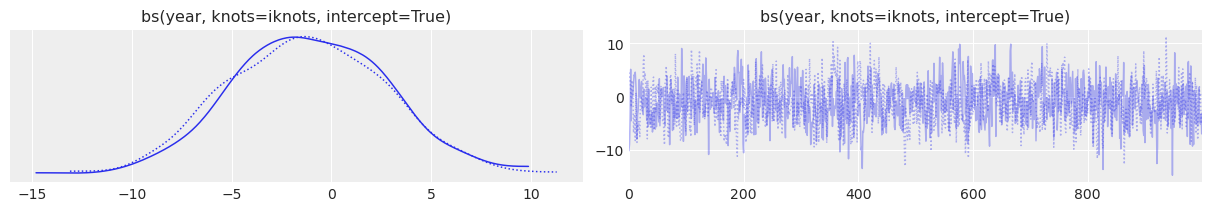

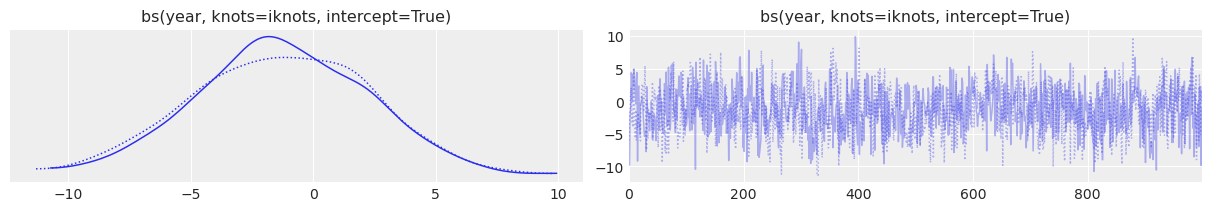

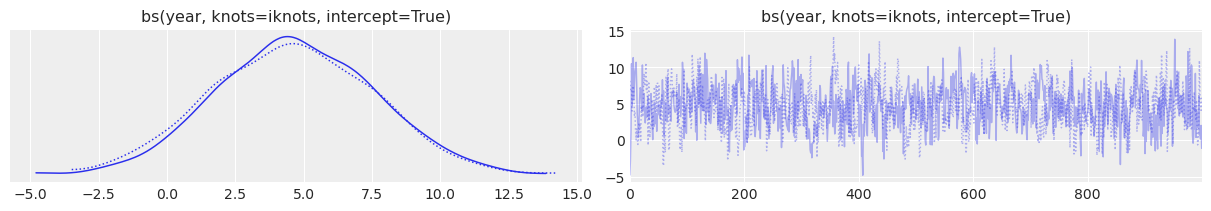

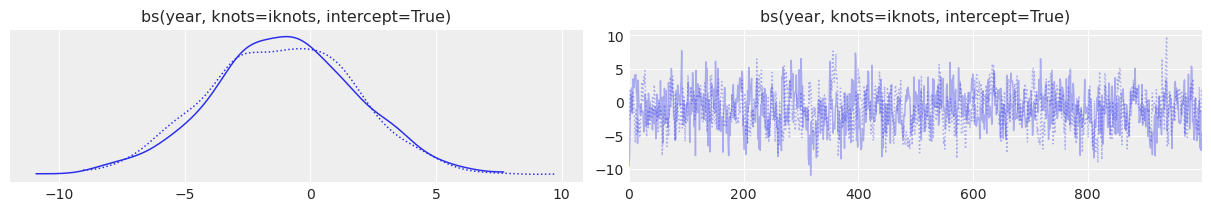

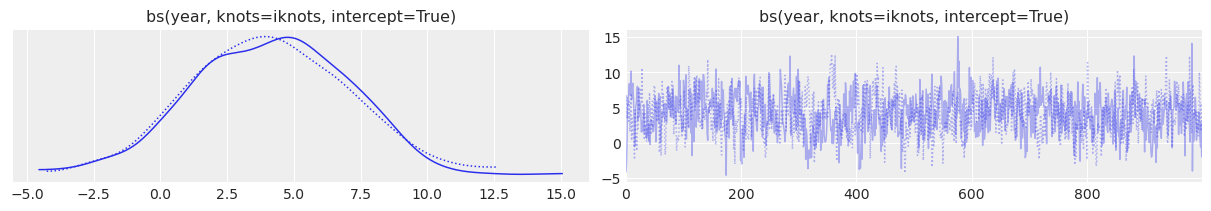

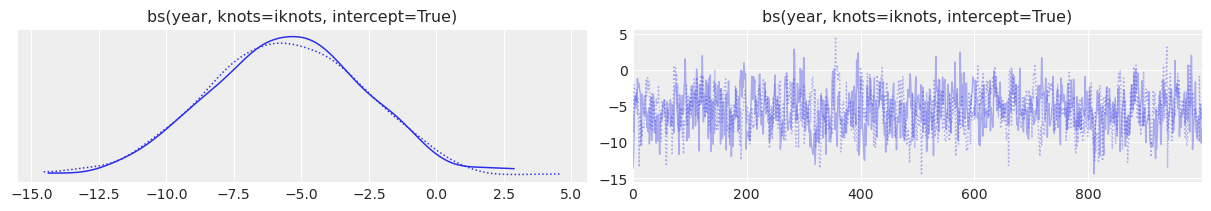

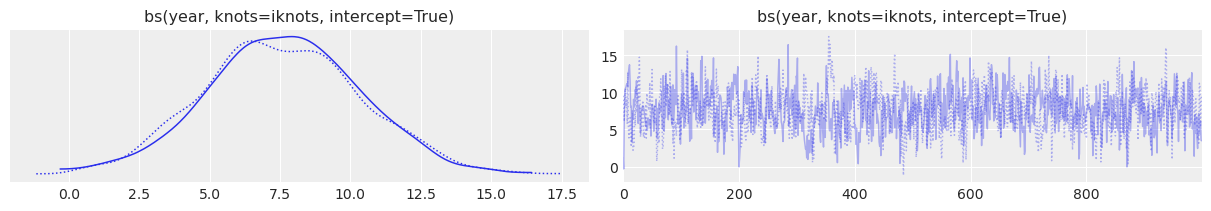

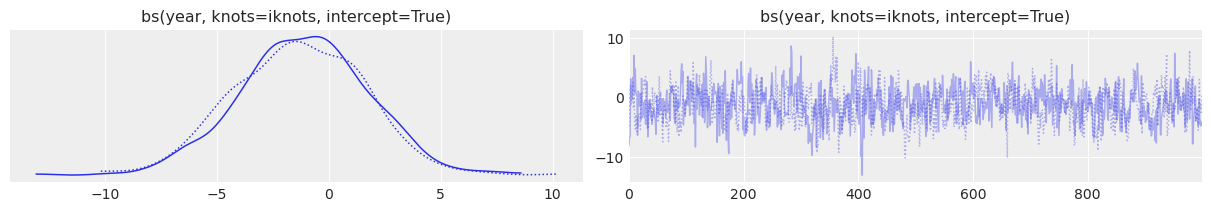

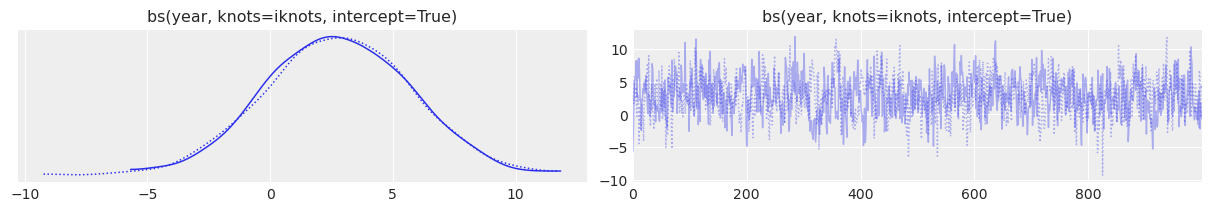

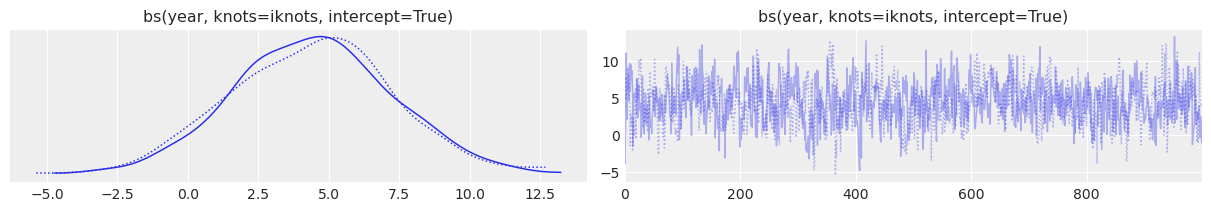

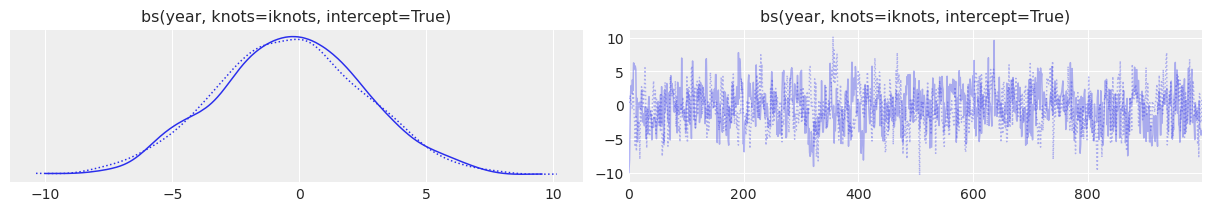

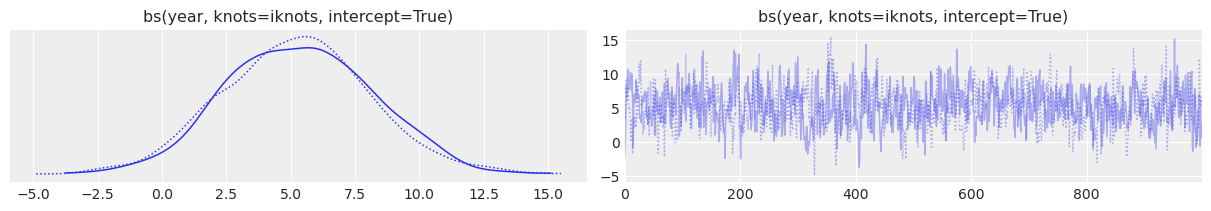

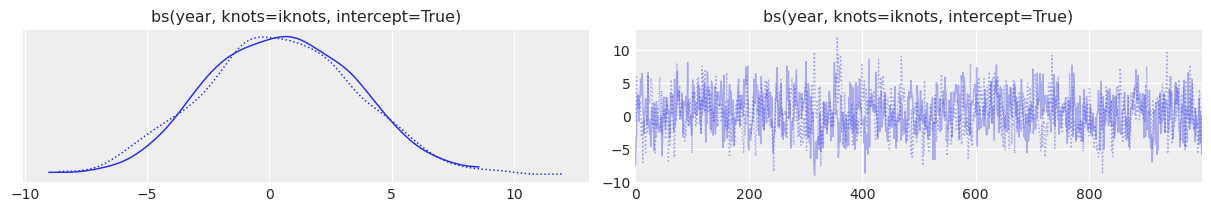

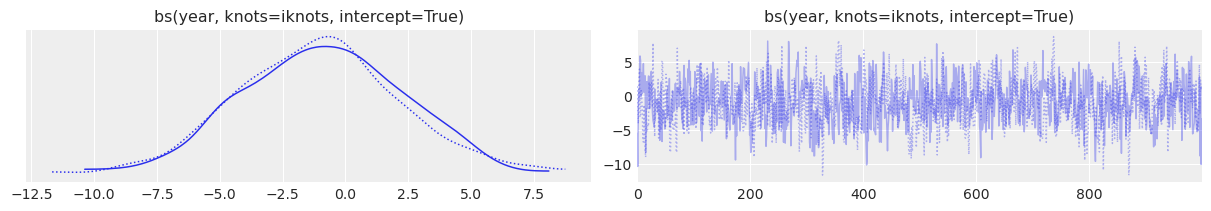

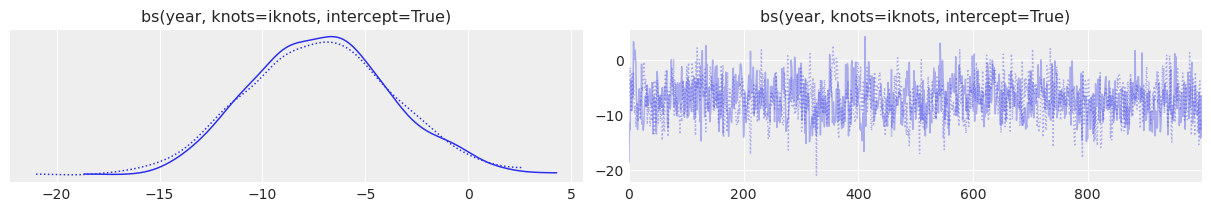

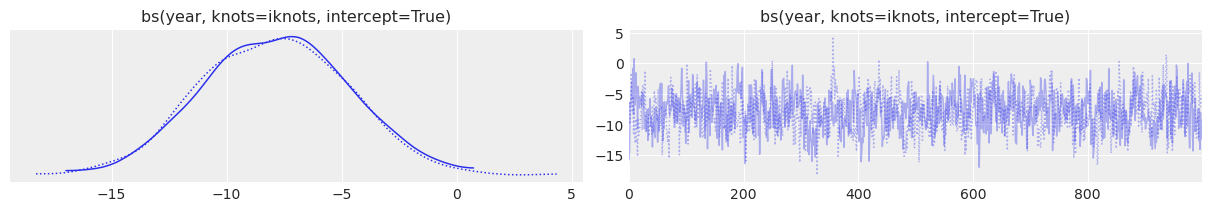

In [16]:
for i in range(0, 17):
    az.plot_trace(idata.posterior["bs(year, knots=iknots, intercept=True)"][:,:,i]);

Ahora podemos ver los polinomios ajustados y la spline.

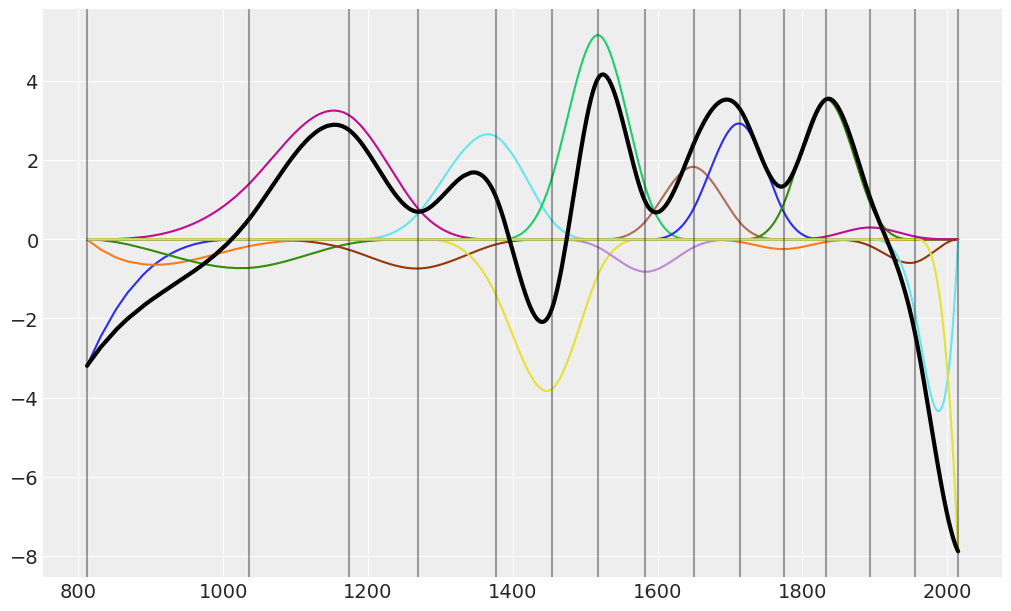

In [17]:
posterior_stacked = az.extract(idata)
wp = posterior_stacked["bs(year, knots=iknots, intercept=True)"].mean("sample").values

ax = plot_spline_basis(B * wp.T, data["year"].values)
ax.plot(data.year.values, np.dot(B, wp.T), color="black", lw=3)
plot_knots(knots, ax);

## Gráfico de Predicciones e intervalos de credibilidad

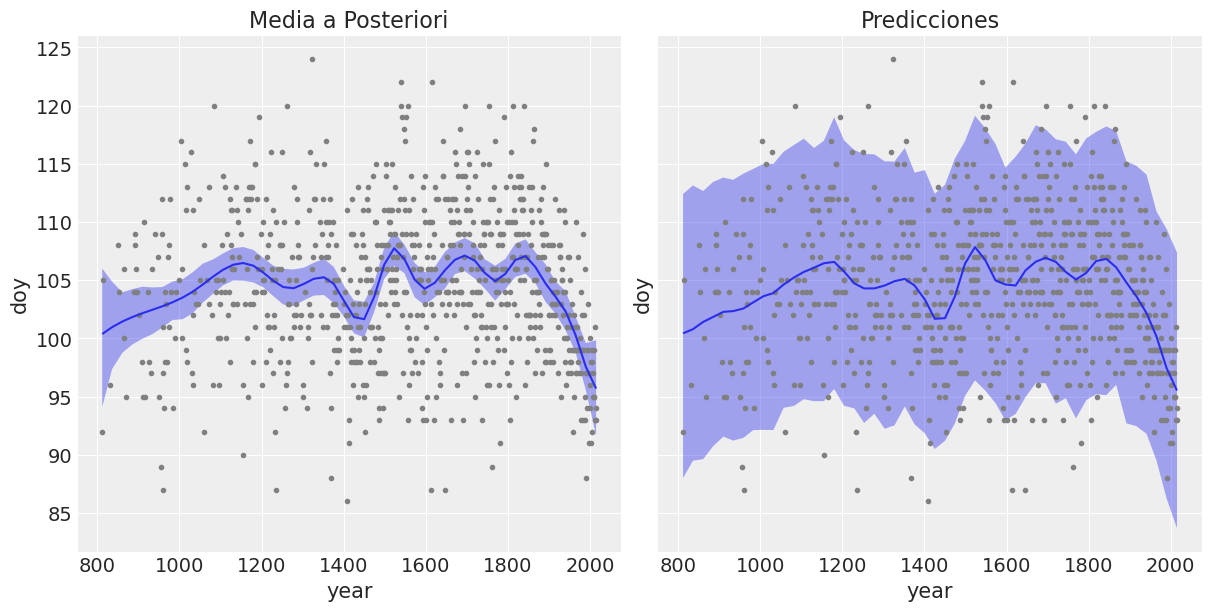

In [18]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
bmb.interpret.plot_predictions(model, idata, 'year', ax=ax[0])
bmb.interpret.plot_predictions(model, idata, 'year', pps=True, ax=ax[1])

ax[0].plot(data.year, data.doy, '.', color='grey', zorder=1)
ax[1].plot(data.year, data.doy, '.', color='grey', zorder=1)
ax[0].set_title('Media a Posteriori')
ax[1].set_title('Predicciones');

## Matriz de diseño y dependencia lineal

Al ver la ``.shape`` de la matriz de diseño:

In [19]:
model.components["doy"].design.common.design_matrix.shape

(827, 18)

Vemos que 827 son las observaciones y 18 los coeficientes del modelo. Tenemos la primera columna de unos por el intercepto, 16 coeficientes asociados a los polinomios y, finalmente, tenemos una columna extra por haber usado ``intercept=True`` en la formula. 

Computamos el rango de la matriz para ver si las columnas son independientes

In [20]:
np.linalg.matrix_rank(model.components["doy"].design.common.design_matrix)

17

Hay una columna que es linealmente dependiente.

El problema es que estamos definiendo el intercepto dos veces

### Creamos un modelo nuevo

Creamos un modelo sin el termino ``intercept=True`` y con los mismos _priors_.

In [21]:
model_new = bmb.Model("doy ~ bs(year, knots=iknots, intercept=False)", data, priors=priors)
idata_new = model_new.fit(random_seed=SEED, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [doy_sigma, Intercept, bs(year, knots=iknots, intercept=False)]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 99 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


### Analisis de resultados

Miramos el summary

In [22]:
az.summary(idata_new)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,102.363,2.006,98.658,106.126,0.109,0.077,342.0,617.0,1.0
"bs(year, knots=iknots, intercept=False)[0]",-0.822,3.905,-7.943,6.599,0.167,0.118,549.0,944.0,1.0
"bs(year, knots=iknots, intercept=False)[1]",0.371,3.007,-5.128,5.881,0.098,0.069,948.0,1369.0,1.0
"bs(year, knots=iknots, intercept=False)[2]",5.706,2.630,0.809,10.785,0.114,0.081,536.0,943.0,1.0
"bs(year, knots=iknots, intercept=False)[3]",0.207,2.537,-4.482,4.828,0.112,0.079,518.0,962.0,1.0
"bs(year, knots=iknots, intercept=False)[4]",5.241,2.613,0.143,9.980,0.112,0.079,544.0,943.0,1.0
"bs(year, knots=iknots, intercept=False)[5]",-4.294,2.454,-8.577,0.653,0.110,0.078,497.0,969.0,1.0
"bs(year, knots=iknots, intercept=False)[6]",8.807,2.541,4.281,13.805,0.114,0.081,494.0,829.0,1.0
"bs(year, knots=iknots, intercept=False)[7]",-0.000,2.626,-5.022,4.810,0.115,0.081,522.0,959.0,1.0
"bs(year, knots=iknots, intercept=False)[8]",4.001,2.657,-1.057,8.779,0.119,0.084,499.0,841.0,1.0


Vemos que tenemos un coeficiente menos, los ``ess`` mejoraron y los ``r_hat`` siguen en 1.

También podemos comparar el tiempo de sampleo

In [23]:
idata.posterior.sampling_time

71.85117268562317

In [24]:
idata_new.posterior.sampling_time

99.25334167480469

Generalmente el sampler corre más rápido cuando no hay dependencias lineales.

Vemos las predicciones y comparemos con el modelo anterior

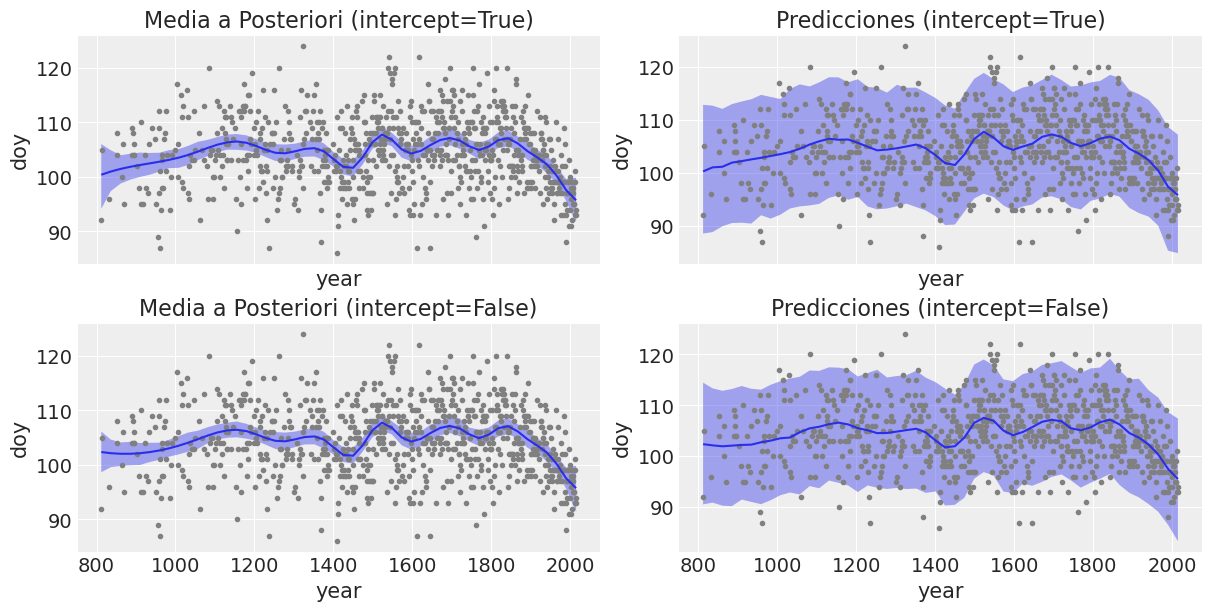

In [25]:
_, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 6))
bmb.interpret.plot_predictions(model, idata, 'year', ax=ax[0,0])
bmb.interpret.plot_predictions(model, idata, 'year', pps=True, ax=ax[0,1])
bmb.interpret.plot_predictions(model_new, idata_new, 'year', ax=ax[1,0])
bmb.interpret.plot_predictions(model_new, idata_new, 'year', pps=True, ax=ax[1,1])

ax[0,0].plot(data.year, data.doy, '.', color='grey', zorder=1)
ax[0,1].plot(data.year, data.doy, '.', color='grey', zorder=1)
ax[1,0].plot(data.year, data.doy, '.', color='grey', zorder=1)
ax[1,1].plot(data.year, data.doy, '.', color='grey', zorder=1)

ax[0,0].set_title('Media a Posteriori (intercept=True)')
ax[0,1].set_title('Predicciones (intercept=True)');
ax[1,0].set_title('Media a Posteriori (intercept=False)')
ax[1,1].set_title('Predicciones (intercept=False)');

### Comparacion de modelos

In [26]:
models_dict = {"Original": idata, "New": idata_new}
df_compare = az.compare(models_dict)
df_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
New,0,-2657.619278,15.811364,0.000000,1.0,21.224990,0.000000,False,log
Original,1,-2658.366912,16.678421,0.747635,0.0,21.197064,0.547626,False,log


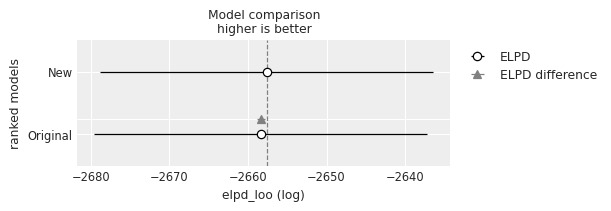

In [27]:
az.plot_compare(df_compare, insample_dev=False);

In [28]:
# Compute pointwise LOO
loo_original = az.loo(idata, pointwise=True)
loo_new = az.loo(idata_new, pointwise=True)

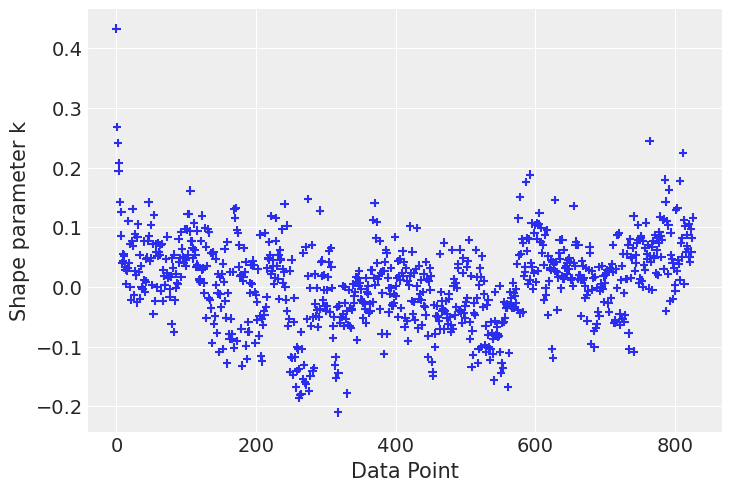

In [29]:
# plot kappa values
az.plot_khat(loo_original.pareto_k);

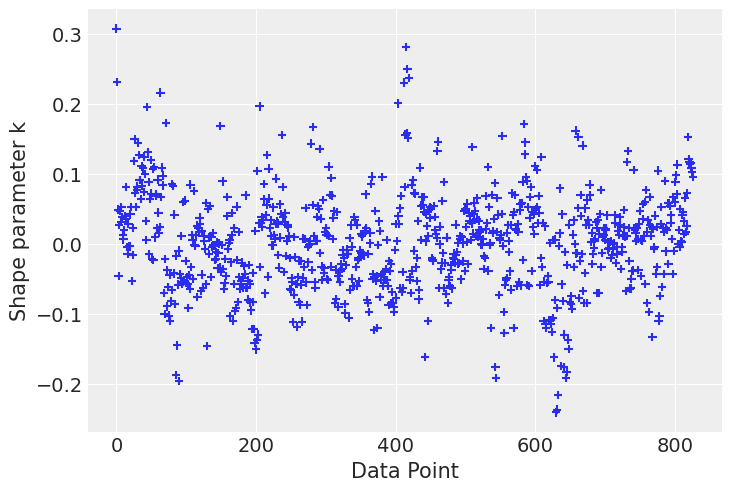

In [30]:
az.plot_khat(loo_new.pareto_k);